This notebook is an adaptation from the LSTM course at JKU, specifically by the one regarding next-character generation with LSTM. I thus retain the original author and copyright statement

# Becoming Shakespeare with the Long Short Term Memory

*Author:* Thomas Adler (adapted by Laura Legat)

*Copyright statement:* This  material,  no  matter  whether  in  printed  or  electronic  form,  may  be  used  for  personal  and non-commercial educational use only.  Any reproduction of this manuscript, no matter whether as a whole or in parts, no matter whether in printed or in electronic form, requires explicit prior acceptance of the authors.

## Becoming Shakespeare with the Long Short Term Memory

In this notebook, you will learn how to generate sonnets like Shakespeare himself by training a so-called Long Short Term Memory (LSTM) model. A LSTM is a type of recurrent neural network (RNN), another different neural network architecture commonly used to learn and generate sequential data, such as natural text, chemical strings, DNA etc. In RNNs, the order of the elements is important, and the LSTM cell contains an internal memory, or state, of the past, enabling them to predict the next element based on that state. The vanilla RNN suffers from a few disadvantages, among which the so-called [vanishing gradient problem](https://en.wikipedia.org/wiki/Vanishing_gradient_problem), which led to the creation of the LSTM - a robust architecture which is suitable for long-term dependency understanding and does not suffer from quadratic complexity like the [Transformer](https://en.wikipedia.org/wiki/Transformer_(deep_learning_architecture)) architecture.

Like we did in the past notebooks, we will define our network structure, this time as a Python class for our LSTM, and then train/evaluate using a curated dataset of Shakespeare's sonnets. Finally, we will use our trained LSTM to generate text similar to the sonnets, and try to get good at imitating Shakespeare's writing style. As a first step, we import our dependencies:

In [152]:
import re
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm

And we set our device to either CPU or GPU:

In [153]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print('Device: ', device)

Device:  cuda


## The data: Shakespeare's sonnets

Shakespeare's sonnets can be found through the following URL: http://shakespeare.mit.edu/

The authors of [this notebook](https://colab.research.google.com/github/ccc-frankfurt/Practical_ML_SS21/blob/main/week06/Shakespeare_Poetry_Generation_RNN_LSTM_solution.ipynb#scrollTo=stneSw5L77Ln) have extracted all the plain text of the sonnets here: https://ocw.mit.edu/ans7870/6/6.006/s08/lecturenotes/files/t8.shakespeare.txt  

We will thus download it from there.

In [106]:
!wget https://raw.githubusercontent.com/ccc-frankfurt/Practical_ML_SS21/master/week06/sonnets.txt

--2025-04-20 00:58:17--  https://raw.githubusercontent.com/ccc-frankfurt/Practical_ML_SS21/master/week06/sonnets.txt
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.109.133, 185.199.110.133, 185.199.108.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.109.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 94081 (92K) [text/plain]
Saving to: ‘sonnets.txt’

sonnets.txt         100%[===================>]  91.88K  --.-KB/s    in 0.02s   

2025-04-20 00:58:17 (3.62 MB/s) - ‘sonnets.txt’ saved [94081/94081]



Let's observe and verify parts of the sonnets:

In [154]:
# open the downloaded file in r=read mode
with open('sonnets.txt', 'r') as f:
    text = f.read()

# print an excerpt of the text
print(text[:700])

From fairest creatures we desire increase,
That thereby beauty's rose might never die,
But as the riper should by time decease,
His tender heir might bear his memory:
But thou contracted to thine own bright eyes,
Feed'st thy light's flame with self-substantial fuel,
Making a famine where abundance lies,
Thy self thy foe, to thy sweet self too cruel:
Thou that art now the world's fresh ornament,
And only herald to the gaudy spring,
Within thine own bud buriest thy content,
And, tender churl, mak'st waste in niggarding:
Pity the world, or else this glutton be,
To eat the world's due, by the grave and thee.

When forty winters shall besiege thy brow,
And dig deep trenches in thy beauty's field,


We can observe nicely that the sonnets are separated by two new lines.

We now want to split the sonnets into a train and validation set. Logically, we want to retain sonnets as a whole, such that only whole sonnets are part of either train/val split. Hence, we first separate the sonnets and then split them 80-20% into training and validation set, respectively.

In [155]:
sonnet_list = [s.strip() for s in text.split('\n\n') if s.strip()]
split_idx = int(0.8 * len(sonnet_list))

# split whole sonnets into train and validation sets
train_sonnets = sonnet_list[:split_idx]
val_sonnets = sonnet_list[split_idx:]

# concat them back to strings again for the model and encoder to work
train_text = '\n\n'.join(train_sonnets)
val_text = '\n\n'.join(val_sonnets)

Next, we define a so-called alphabet, or vocabulary, which basically contains all unique tokens of a text. An alphabet could for instance be all letters from A-Z, or include numerical characters, or special tokens.

In [156]:
vocab = sorted(set(text)) # get all unique characters -> alphabet

vocab = ''.join(vocab) # concatenate to singular string
vocab

"\n !'(),-.:;?ABCDEFGHIJKLMNOPRSTUVWYabcdefghijklmnopqrstuvwxyz"

## Generating character encodings

To be able to feed text into RNNs, we first have to choose a good representation, meaning an abstraction of the text into numeric format, since that is what the RNN expects. There are several options to do so ranging from simpler character embeddings to more sophisticated approaches like [word embeddings](https://towardsdatascience.com/introduction-to-word-embedding-and-word2vec-652d0c2060fa) and more.

We will use character embeddings in this notebook, which work as follows: First we define an alphabet, which we then take and map each alphabet token to a unique integer/ID. This ID will further be vectorized, becoming a character embedding.

For simplicity, we define our alphabet here as "all unique letters in our text, including special characters such as \n". We abstract this functionality into an `Encoder` class, which creates the mapping from character to integer in the form of a `dict` in the `__init__()` method. Let's the how the encoding works:

In [157]:
class Encoder():
    def __init__(self, alphabet):
        self.alphabet = dict(enumerate({*alphabet})) # star operator (*) unpacks alphabet letter-by-letter, enumerate returns tuple(idx, letter) for each letter and dict takes idx as key and letter as value, leaving us with an alphabet dict with structure: {encoded: letter}

    def __call__(self, input_arg):
        if isinstance(input_arg, str): # if input is a string, convert it to an encoded int Tensor

            # for each letter in the input string, go through alphabet dict and extract corresponding key/encoded int
            encoding = torch.tensor([next(idx for idx, letter in self.alphabet.items() if letter in input_letter) for input_letter in input_arg])
            return encoding

        elif isinstance(input_arg, torch.Tensor): # if input is a Tensor, convert it to a string
            # for each int in the input tensor, go through alphabet dict and extract corresponding value/letter, then concatinate them for the whole input tensor
            text = "".join([next(letter for idx, letter in self.alphabet.items() if idx in input_idx) for input_idx in input_arg])
            return text

# testing the Encoder
LSTM_Encoder = Encoder(vocab)
encoded = LSTM_Encoder.__call__("Hello World! \n")
print(encoded)
decoded = LSTM_Encoder.__call__(encoded)
print(decoded)

tensor([32, 15,  9,  9,  3, 31, 25,  3, 22,  9, 34,  1, 31, 28])
Hello World! 



In [158]:
LSTM_Encoder.alphabet[32]

'H'

As you see, the uppercase H has been mapped to the integer 32, and 32 is also the first index to appear in our encoded sequence. We can also observe the total text length of our dataset, and how many unique characters our alphabet contains:

In [159]:
print('Total characters: ', len(text))
print('Vocabulary size: ', len(LSTM_Encoder.alphabet))

Total characters:  94081
Vocabulary size:  61


Next, we need to think about our goal, which is to generate text similar to Shakepeare's sonnets. Since we use a character-based approach, we can simplify our goal down to "we want to predict the next character given the past characters", where "the past characters" is a defined look-back window, e.g. predicting the next character based on the past 100 characters before it. That is, with character 1 to 100 as input, the LSTM is going to predict character 101. For example, imagine a look-back window of length 3:

hel -> l

ell -> o

llo -> !

and so on. We can frame this as a classification problem: given a look-back window, predict the next most likely class (letter) our of all possible classes (alphabet). Hence, our training data will consist of fixed-sized look-back windows of text, and the labels will be the next characters, given the corresponding window. Thus, we need to split our whole sonnet textual data into such windows. For this, we are utilizing the `torch.utils.data.Dataset` class and adjusting the `TextDataset` class for our task.

In [160]:
class TextDataset(Dataset):
    def __init__(self, text, l, encoder):
        super().__init__()

        # encode whole text
        self.encoder = encoder
        self.encoded_text = encoder.__call__(text)

        # split encoded text into look-back windows of length l
        self.encoded_samples = [self.encoded_text[i:i+l] for i in range(0, len(text), l)]

        # remove incomplete sequences (where elements are less than wanted sequence length)
        self.encoded_samples = [sample for sample in self.encoded_samples if sample.numel() == l]

    def __len__(self):
        return len(self.encoded_samples)

    def __getitem__(self, sample_idx):
        return self.encoded_samples[sample_idx]

Next, we utilize it similar to how we did in the past notebooks, as well as specify a look-back window length and the encoder it should use for mapping the characters in the `text` argument to integers that a neural network can work with. We finally wrap the datasets into a `DataLoader` for efficient batching.

In [161]:
window_size = 100 # look-back window length, feel free to play around with this value
batch_size = 256

# create datasets out of the encoded texts
training_set = TextDataset(text=train_text, l = window_size, encoder = LSTM_Encoder)
val_set = TextDataset(text=val_text, l = window_size, encoder = LSTM_Encoder)

# wrap datasets into dataloaders
train_dataloader = DataLoader(training_set, batch_size = batch_size, shuffle=True)
val_dataloader = DataLoader(val_set, batch_size = batch_size)

## Define simple LSTM architecture



Next, we define a simple LSTM architecture that will predict the next character given a sequence of characters in the form of a look-back window. Here, the concept of an embedding layer is introduced. The encoded integers constitute the input to the embedding layer, which transforms them into a high-dimensional latent space representation. This latent space contains, after training, a learned representation of the input text, which captures the model's understanding of it.

In [162]:
class NextCharLSTM(nn.Module):
    def __init__(self, alphabet_size, embedding_dim, hidden_dim, num_layers, dropout):
        super().__init__()

        # declaring model params
        self.alphabet_size = alphabet_size
        self.embedding_dim = embedding_dim
        self.hidden_dim = hidden_dim

        # setting up layers as per description
        self.embedding = nn.Embedding(num_embeddings=alphabet_size, embedding_dim=embedding_dim)
        # specify here that the batch dimension will be the first dimension
        self.lstm = nn.LSTM(input_size=embedding_dim, hidden_size=hidden_dim, batch_first=True, num_layers=num_layers)
        self.fc = nn.Linear(in_features=hidden_dim, out_features=alphabet_size)

        self.dropout = nn.Dropout(dropout)

    def forward(self, input_sequence):
        embedded_sequence = self.embedding(input_sequence)
        lstm_out, _ = self.lstm(embedded_sequence)
        lstm_out = self.dropout(lstm_out)
        logits = self.fc(lstm_out)
        return logits

We define certain parameters for our training setup, some of which are new:

*   **Embedding dimension:** This will give us fixed-size vector representations of our encoded characters, e.g. an embedding dimension of 64 embeds each character into a 64-numbers long vector. For this notebook, we choose a quite large embedding dimension due to the complexity of Shakespeare's texts
*   **Number of layers:** This defines how many consecutive LSTM layers there are in the model. We increased this to 2 in order to be able to capture more complexity in the data

In [168]:
# feel free to play around with these values
embedding_dim = 256
hidden_dim = 512
alphabet_size = len(training_set.encoder.alphabet)
num_layers = 2
dropout = 0.3

model = NextCharLSTM(alphabet_size, embedding_dim, hidden_dim, num_layers=num_layers, dropout=dropout)
print(model)

NextCharLSTM(
  (embedding): Embedding(61, 256)
  (lstm): LSTM(256, 512, num_layers=2, batch_first=True)
  (fc): Linear(in_features=512, out_features=61, bias=True)
  (dropout): Dropout(p=0.3, inplace=False)
)


We print our model size, i.e. the total number of parameters. It is always useful to keep track of this, especially when working within hardware constraints:

In [169]:
print('Numer of parameters: ', sum([torch.numel(p) for p in model.parameters()]))

Numer of parameters:  3725117


## Model training

Next, we set up our training and evaluation loops, this time both encapsulated in one `epoch` function:

In [170]:
def epoch(dataloader, model, optim=None):
    device = next(model.parameters()).device
    criterion = nn.CrossEntropyLoss() # use Cross Entropy Loss for multi-class problems
    losses = []

    if optim is None: # validate model
        model.eval() # set model to evaluation mode

        with torch.no_grad():
            for mini_batch in dataloader:
              # split up each sequence
                input_sequence = mini_batch[:, :-1].to(device)
                target_sequence = mini_batch[:, 1:].to(device)

                logits = model(input_sequence)
                logits = logits.reshape(-1, model.alphabet_size)
                loss = criterion(logits, target_sequence.reshape(-1))
                losses.append(loss.item())
        return np.array(losses)

    else: # train model
        model.train() # set model into training mode

        for mini_batch in dataloader:
            # split each sequence up into (a) first to second-to-last item -> input sequence, and (b) second to last item -> target sequence
            input_sequence = mini_batch[:, :-1].to(device)
            target_sequence = mini_batch[:, 1:].to(device)

            optim.zero_grad() # resets grads for every batch

            logits = model(input_sequence) # forward pass through our NextCharLSTM
            logits = logits.reshape(-1, model.alphabet_size)

            # calculate loss
            loss = criterion(logits, target_sequence.reshape(-1))

            loss.backward() # backprop through the model
            optim.step() # update weights

            losses.append(loss.item())
        return np.array(losses)

We run the above training code and visualize how the training and validation losses change over the epochs.

Training NextCharLSTM...: 100%|██████████| 100/100 [00:05<00:00, 19.42it/s]


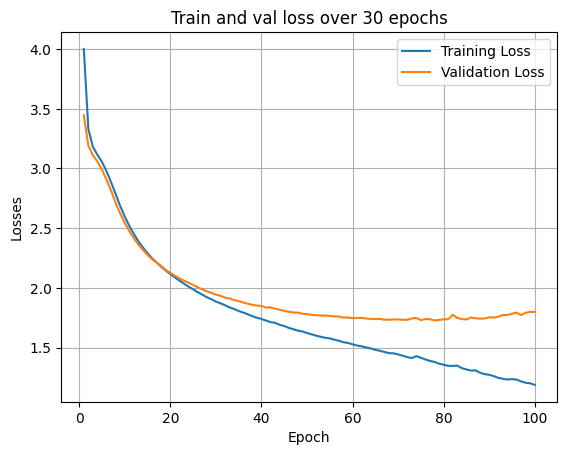

In [171]:
# feel free to play around with these values
learning_rate = 1e-3
num_epochs = 100
model = model.to(device)

# add weight decay to mitigate overfitting
optim = torch.optim.Adam(params = model.parameters(), lr=learning_rate, weight_decay=5e-5)

train_losses = []
val_losses = []
best_val_loss = float('inf')

# train/val loop
for ep in tqdm(range(num_epochs), desc='Training NextCharLSTM...'):
    # collect training and validation losses for current epoch, calculate the mean loss per currect epoch and add it to train_losses list
    train_losses_ep = epoch(train_dataloader, model, optim)
    avg_train_loss = np.mean(train_losses_ep)
    train_losses.append(avg_train_loss)

    val_losses_ep = epoch(val_dataloader, model, None)
    avg_val_loss = np.mean(val_losses_ep)
    val_losses.append(avg_val_loss)

# visualization
plt.plot(range(1, num_epochs+1), train_losses, label='Training Loss')
plt.plot(range(1, num_epochs+1), val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Losses')
plt.legend()
plt.title('Train and val loss over 30 epochs')
plt.grid(True)
plt.show()

We observe that both the training and the validation loss decrease nicely. However, we also observe that the validation loss starts staggering around epoch 60 - something that can be further mitigated, however is not the focus of this notebook.

## Generate new sonnets

Now that you have a trained model for predicting next-characters of Shakespeare sonnets, it is time to see it in action!

In [176]:
def generate_text(model, encoder, vocab, start_string, window_size, generation_length=500, temperature=1.0):
    model.eval() # for inference only

    # initialize encoded start prompt
    input_seq = encoder(vocab).unsqueeze(0).to(device)  # Add batch dim
    generated_text = start_string

    for _ in range(generation_length): # generate for as long as specified
        with torch.no_grad():
            # we only need last prediction, i.e. the next character
            logits = model(input_seq)[:, -1, :] / temperature

            # Convert to probabilities
            probs = F.softmax(logits, dim=-1)

            # Sample from distribution
            next_char_idx = torch.multinomial(probs, num_samples=1).item()
            next_char = encoder.alphabet[next_char_idx]

            # Append to generated text
            generated_text += next_char

            # Update input sequence (sliding window)
            new_char_tensor = torch.tensor([[next_char_idx]], device=device)
            if input_seq.size(1) >= window_size:
                input_seq = torch.cat([input_seq[:, 1:], new_char_tensor], dim=1)
            else:
                input_seq = torch.cat([input_seq, new_char_tensor], dim=1)

    # Format the output with proper capitalization
    sentences = [s.capitalize() for s in generated_text.split('.')]
    formatted_text = '. '.join(sentences)

    return formatted_text

# Example usage:
seed_text = "Thou shall"
generated_speech = generate_text(
    model=model,
    encoder=LSTM_Encoder,
    vocab=vocab,
    start_string=seed_text,
    window_size=window_size,
    generation_length=1000,
    temperature=0.7
)
print(generated_speech)

Thou shallend with this face with thoughts of exce:
the one glass tho piel these strongs and speat,
and painted nothing all find thou wert from thee
so those that from the wasted with stay thy stol
of that with my foot on thy course of thee to still. 

that i see the strong to the parts, do not come as stoce thy shows,
but excuse, but that time's time debated,
and for a matcely shall have stands to his,
and you you attent i hamp posteritest within thine in their rate?
with thy shalt my soul every then fy stage,
for that it seep this tothers common to my state,
which that thou wouldst love him live your grated,
he please of the all on the stand,
and burn the rages graced for they you, that which i be better thought,
and all those shape a for well the might the desay,
if see the distorly spite them so mades
with me, my love all those can adless and ead;
that a pen a thing the world shall be thy beauty distaccettance. 
and of heaving his bue, what is all be disgrace. 
nor thou with the to